# Fig1 - tRNA map, reconstructions and log odds table

In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import argparse
from collections import OrderedDict
from torch.utils.data import DataLoader
from datasets import Dataset
import torch.nn as nn
import time
from plotnine import *
import pyranges as pr
import seaborn as sns
from matplotlib.patches import Rectangle
import contextlib
from torch.amp import autocast
import itertools
import tqdm

data_path = 'data'

In [3]:
os.chdir(os.path.join(project_path, 'dna-lm-interactions-paper/code_submission'))
from utils import create_load_matrix_function, plot_matrix_with_roi, plot_weights, plot_ci_matrix
from model_wrappers import ReconstructionModel

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling


In [4]:
species_of_interest = 'saccharomyces_cerevisiae'
get_ci_matrix = create_load_matrix_function(species_of_interest)

Loading dataframes with snp preds...


In [13]:
species = 'Saccharomyces_cerevisiae_BY4741'
real_seqs_df = pd.read_csv(os.path.join(os.path.join(data_path, 'Saccharomyces_cerevisiae_BY4741_upstream_1000bp_with_start_cds_downstream_509bp_with_stop_longest_cds.tsv'))
, sep='\t')

<module 'matplotlib.pyplot' from '/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

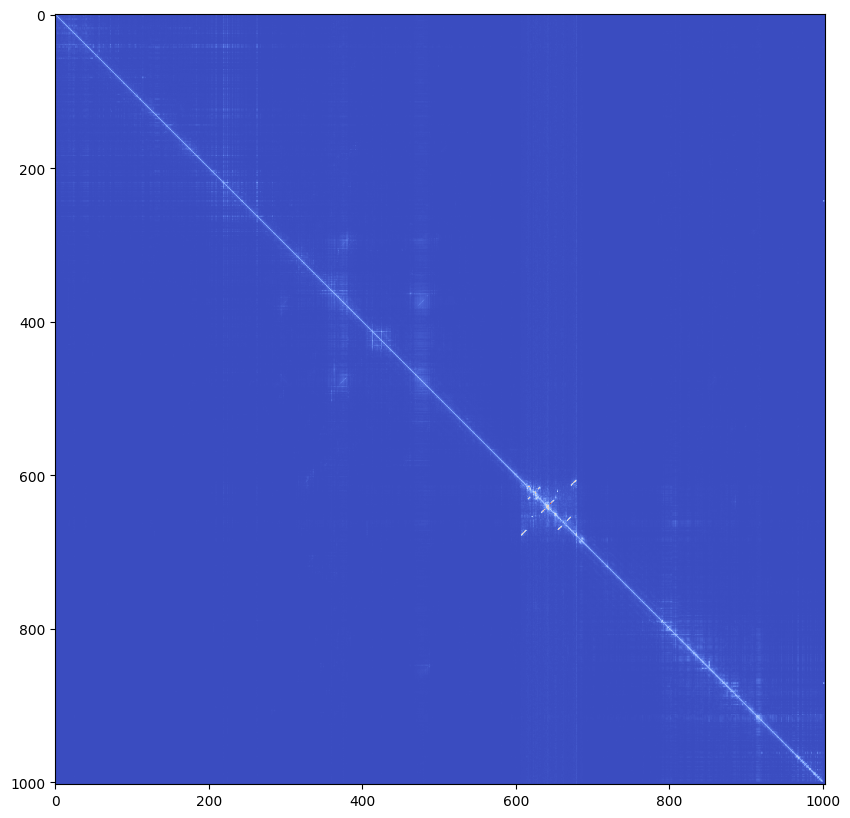

In [14]:
gene_id = 'YOR007C'
ci_matrix = get_ci_matrix(gene_id)
plot_ci_matrix(ci_matrix)

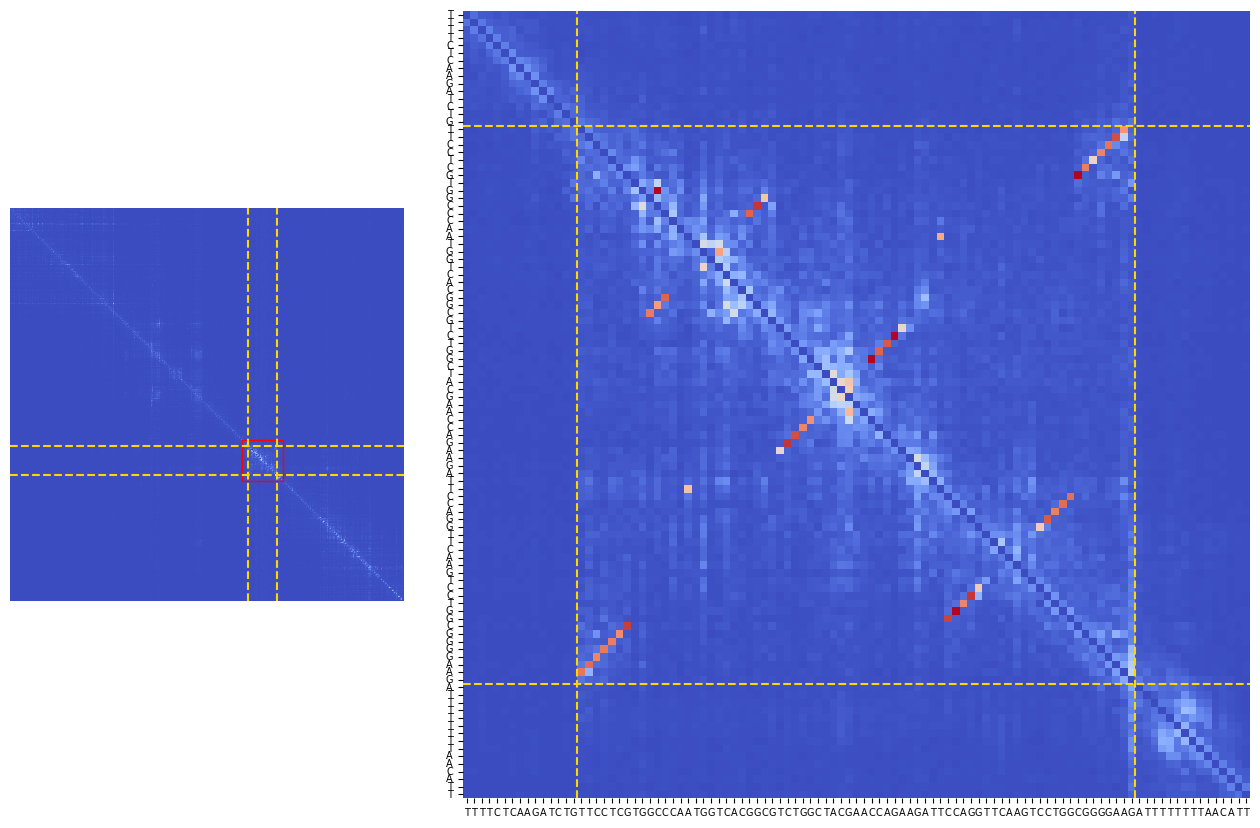

In [6]:
gene_seq = real_seqs_df[real_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[0])] = 0
plot_matrix_with_roi(ci_matrix, gene_seq, [607, 680], zoom_slack=15, 
    plot_size=16, width_ratios=[1, 2], vmax=10, display_values=False, annot_size=30, 
    display_dotted_line=True, tick_label_fontsize=7)

In [7]:
gene_id = 'YOR007C'
snp_effect = get_ci_matrix(gene_id, use_logit=True, return_snp_effect=True)
snp_effect.shape

torch.Size([4, 1003, 1003, 4])

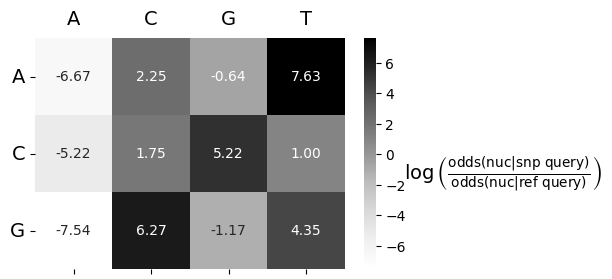

In [8]:
# make a heatmap with a grey color scale
plt.figure(figsize=(5, 3))  

ax = sns.heatmap(snp_effect[:-1, 607, 678, :], cmap='Greys', annot=True, fmt=".2f",
                 xticklabels=['A', 'C', 'G', 'T'], 
                 yticklabels=['A', 'C', 'G'])

# Move the x-axis ticks to the top. also rotate the y axis
ax.tick_params(axis='x', labelbottom=False, labeltop=True, labelsize=14)
ax.tick_params(axis='y', rotation=0, labelsize=14)

#label the color scale as log(P_snp/P_ref)
cbar = ax.collections[0].colorbar
#cbar.set_label('log(P(nuc|snp query)/P(nuc|ref query)', rotation=0, labelpad=65)
cbar.set_label(r'$\log\left(\frac{\mathrm{odds(nuc|snp\ query)}}{\mathrm{odds(nuc|ref\ query)}}\right)$', 
               rotation=0, labelpad=70, fontsize=14)

plt.show()

### Nucleotide reconstruction

In [9]:
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from flash_attn.models.bert import BertModel, BertForPreTraining
model_path = 'species_upstream_1000_k1/'
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)

In [10]:
proxy_species = 'kazachstania_africana_cbs_2517_gca_000304475'
assert proxy_species in tokenizer.get_vocab()

In [11]:
device = "cuda"
model.to(device)
model.eval()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1408, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
    (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): Block(
          (mixer): MHA(
            (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
            (inner_attn): FlashSelfAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (inner_cross_attn): FlashCrossAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, mode=row)
          (norm1): LayerNorm((768,

In [12]:
print(f'GPU Model: {torch.cuda.get_device_name(0)}')

GPU Model: NVIDIA A40


In [13]:
reconstructor = ReconstructionModel(model, tokenizer, require_lm_grad=False)
reconstructor.eval()

ReconstructionModel(
  (lm): BertForPreTraining(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(1408, 768, padding_idx=0)
        (position_embeddings): Embedding(1024, 768)
        (token_type_embeddings): Embedding(2, 768)
      )
      (emb_drop): Dropout(p=0.1, inplace=False)
      (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (encoder): BertEncoder(
        (layers): ModuleList(
          (0): Block(
            (mixer): MHA(
              (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
              (inner_attn): FlashSelfAttention(
                (drop): Dropout(p=0.1, inplace=False)
              )
              (inner_cross_attn): FlashCrossAttention(
                (drop): Dropout(p=0.1, inplace=False)
              )
              (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
            )
            (dropout1): Dropout(p=0.1, inplace=False)
            (drop_

In [14]:
def create_dataloader(dataset, batch_size=64):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(tok_func_species, batched=False,  num_proc=20)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=batch_size, num_workers = 4, shuffle = False, collate_fn=data_collator)

    return data_loader

def tok_func_species(x, proxy_species=proxy_species):
    res = tokenizer(proxy_species + " ".join(list(x['seq'])))
    return res

In [15]:
genes_of_interest = ['YOR007C']
dataset = real_seqs_df[real_seqs_df.gene_id.isin(genes_of_interest)].rename({'five_prime_seq':'seq'},axis=1).loc[:, ['gene_id', 'seq']].copy().reset_index(drop=True)
dataset

,gene_id,seq
0,YOR007C,ATGTTAATTCTTTGAAATGAATACCACCTAATAAAACTATACATTT...


In [16]:
dl = create_dataloader(dataset, batch_size=1)

all_prbs = reconstructor.predict_all_from_dataloader(dl, batch_size=128)

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

1it [00:04,  4.40s/it]


In [17]:
all_prbs.shape

torch.Size([1, 1003, 4])

# Visualization

In [18]:
def compute_log_ratio(nuc_probs):
    nucs_mean = nuc_probs[:-3].mean(axis = 0)
    nucs_normed = nuc_probs * np.log2(nuc_probs/nucs_mean)
    return nucs_normed

In [19]:
def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.325, 0.176, 0.175, 0.324]), #background nucleotide frequency in S cerevisiae
                            pseudocount=0):
    ppm=ppm.unsqueeze(0)
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

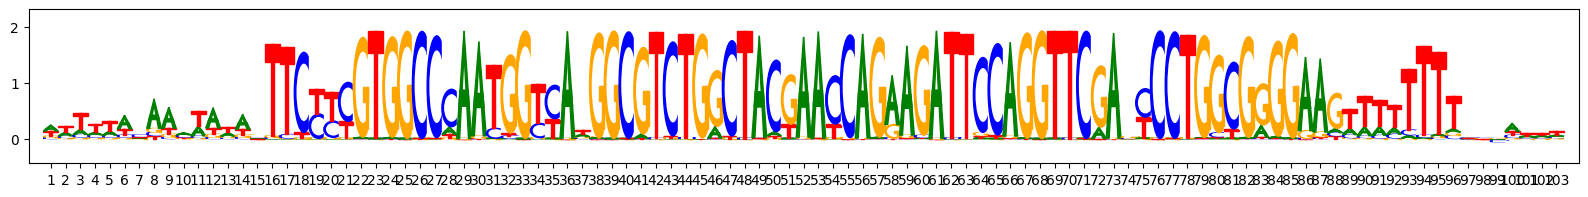

In [20]:
plot_weights((all_prbs[0]*compute_per_position_ic(all_prbs[0]).swapaxes(0,1))[592: 695].numpy(), subticks_frequency=1)

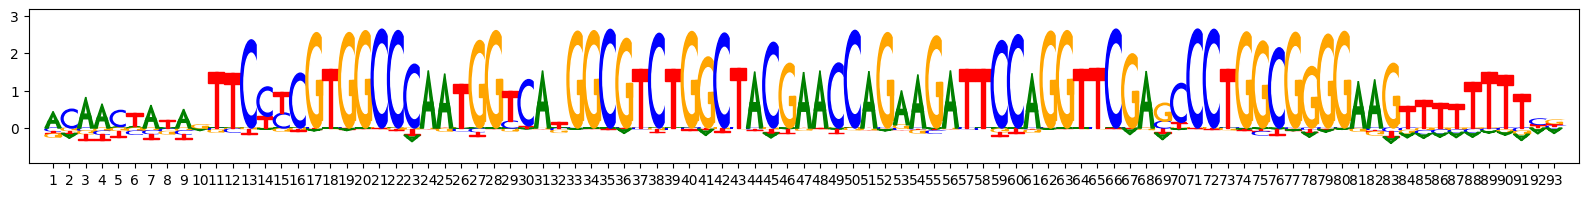

In [21]:
plot_weights(compute_log_ratio(all_prbs[0])[597: 690].numpy(), subticks_frequency=1)

### Reconstruction promoter with repeat + TATA box

In [22]:
genes_of_interest = ['YCR047C', 'YNL339C', 'YNR064C', 'YLR466C-A', 'YFR035C', 'YCL054W-A']
dataset = real_seqs_df[real_seqs_df.gene_id.isin(genes_of_interest)].rename({'five_prime_seq':'seq'},axis=1).loc[:, ['gene_id', 'seq']].copy().reset_index(drop=True)
dataset

,gene_id,seq
0,YCL054W-A,GATCTGTTTAATAGGTTTGCTATAAATGCACAATAATTTTTCACCC...
1,YCR047C,GTGCAGCACCTGATGGCTATCCAGCCCAAGAACATCCATGCGAACA...
2,YFR035C,GTGTACTATTGTCATATTTTATATTTCTAATACAACGTATATAAAA...
3,YLR466C-A,AGACCCATTCACCCACGACGTATCAAGTTACTTCCTTGGTGCAATG...
4,YNL339C,GGCAGGGTAAGTTGAGATGGTATATACTGTAGCATCCGTGTACGTA...
5,YNR064C,ATCGAAAAATTCCCTTATCAACCTGTAAAGGTGGGCTGAAATTGGA...


In [23]:
dl = create_dataloader(dataset, batch_size=1)

all_prbs = reconstructor.predict_all_from_dataloader(dl, batch_size=128)

num_proc must be <= 6. Reducing num_proc to 6 for dataset of size 6.


Map (num_proc=6):   0%|          | 0/6 [00:00<?, ? examples/s]

6it [00:21,  3.56s/it]


In [24]:
all_prbs.shape

torch.Size([6, 1003, 4])

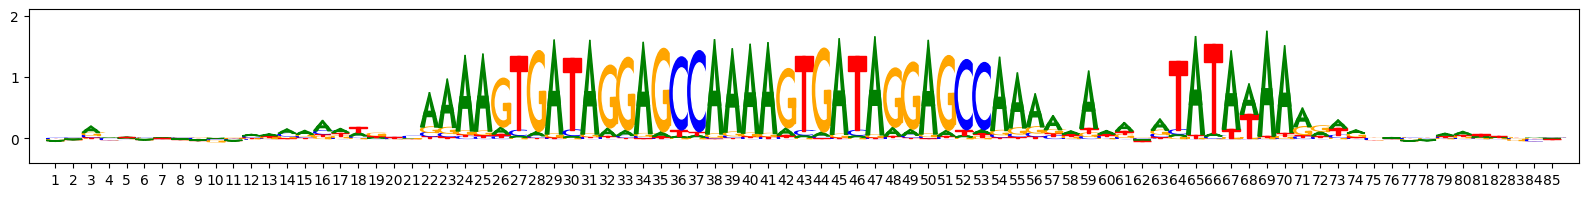

In [25]:
plot_weights((all_prbs[-1]*compute_per_position_ic(all_prbs[-1]).swapaxes(0,1))[865:950].numpy(), subticks_frequency=1)